# Python-1, лекция 16
## Многопоточность в Python

1. [Теоретические аспекты](#theory)
2. [Поток и процесс. Создание процессов и процессов](#process)
3. [Передача данных между потоками при помощи pipe и общей памяти](#gen)
4. [GIL](#GIL)
5. [Асинхронное выполнение потоков](#asynchronous)
6. [Библиотеки threading, multiprocessing и asyncio](#threading)

## Теоретические аспекты. <a name="theory"></a>
- Процесс - это программа, которая выполняется в отдельном
виртуальном адресном пространстве.
- Поток(thread) — наименьшая единица обработки, исполнение
которой может быть назначено ядром операционной системы.\
Несколько потоков выполнения могут существовать в рамках
одного и того же процесса и совместно использовать ресурсы,
такие как память, тогда как процессы не разделяют этих ресурсов.
- Многопоточность — способность платформы (например
виртуальной машины, операционной системы и т.д.) или
приложения выполнять одновременно, то есть без предписанного
порядка во времени, несколько параллельных задач — потоков.

![потоки](cartoons/threat.jpg)

## Цели параллельного программирования

Три главные цели параллельного программирования (в дополнение к целям последовательного программирования):

1. Производительность
2. Эффективность
3. Общность

### Производительность

Тем не менее фокус производительности сдвинулся с аппаратного обеспечения к параллельному программному обеспечению. Этот сдвиг происходит из-за того, что хотя закон Мура продолжает приносить увеличение плотности транзисторов, он перестал увеличивать производительность для традиционных однопоточных программ. Это можно увидеть на графике 1, который показывает, что написание однопоточного кода и простое ожидание догона процессора до нужной производительности через год или два, может уже не быть подходящим вариантом. Учитывая последние тенденции всех главных производителей по отношению к мультиядерным/мультипоточным системам, параллелизм - это выход для тех, кто хочет достичь максимальной производительности от системы.

![photo_1](cartoons/clockfreq.png)

График 1: Тенденция показателя MIPS/тактовая частота для процессоров Intel

Даже так, производительность является более важной, чем масштабируемость, особенно учитывая, что наиболее простой способ достичь линейной масштабируемости - это понизить производительность каждого процессора [Tor01]. Если вам дана 4-процессорная система, что вы предпочтете: программу, которая выполняет 100 транзакций в секунду на одном процессоре, но не масштабируется или программу, которая выполняет 10 транзакций в секунду, но отлично масштабируется? Первый вариант смотрится лучше, однако ответ может изменится, если у вас появится 32-процессорная система. 

Однако, только потому, что у вас есть несколько процессоров, вы не обязаны всех их использовать. Даже учитывая недавние уменьшение цен на мультипроцессорные системы. Ключевая идея в том, что параллельное программирование по своей сути - это оптимизация производительности и, следовательно, все лишь возможная оптимизация из многих доступных. Если ваша программа достаточна быстра в таком виде, в котором она сейчас написана, нет причины оптимизировать ее как путем распараллеливания, так и путем применения потенциальных "классических" последовательных оптимизаций. Кстати, если вы собираетесь применить параллелизм как оптимизацию к последовательной программе, вам надо будет сравнивать параллельные алгоритмы с лучшими последовательными. Это может потребовать некоторого внимания, так как слишком много работ при анализе производительности параллельных алгоритмов игнорируют их последовательные аналоги.

### Эффективность

Сегодня достаточно трудно купить машину с такой маленькой вычислительной мощностью. Возможно, ближайший эквивалент - это 8-битный встраиваемый микропроцессор на базе древнего Z80 [Wik08], но даже старый Z80 имел тактовую частоту процессора, более чем в 1000 раз превышающую CSIRAC. Процессор Z80 имел 8500 тысяч транзисторов и мог быть куплен в 2008 году менее, чем за 2$ US за штуку партиями по тысяче. На контрасте с CSIRAC, цена разработки программного обеспечения может являться всем, чем угодно, но не важным фактором для Z80.

CSIRAC и Z80 - две точки в долговременной тенденции, как мы можем видеть на графике 2.

![photo_2](cartoons/mipsperbuck.png)

График 2: MIPS на кристалл для процессоров Intel

Этот график отображает аппроксимацию вычислительной мощности на кристалл за последние три десятилетия и показывает постоянное увеличение этой величины на 4 порядка. Надо учитывать, что приход мультиядерных процессоров сделал возможным продолжение этого увеличения, несмотря на потолок тактовой частоты, с которым столкнулись инженеры в 2003 году.

Одно из неизбежных последствий быстрого уменьшения цен на аппаратное обеспечение, это то, что эффективность программного обеспечения становится все более важной. Теперь недостаточно просто эффективно использовать "железо": вместе с ним необходимо крайне эффективно использовать разработчиков ПО. Это давно уже не новость для последовательного аппаратного обеспечения, но параллельное аппаратное обеспечение стало недорогим только недавно. Именно поэтому высокая эффективность стала критично важной при создании параллельного программного обеспечения.


### Общность
Один из способов оправдать высокую цену разработки параллельного программного обеспечения, это достижение максимальной общности. При всех прочих равных, более общий программный артефакт может быть распространен между большим количеством пользователей, чем менее общий.

К сожалению, за счет общности часто приходится жертвовать производительностью, эффективностью или тем и другим. Для того чтобы увидеть это, рассмотрим следующие популярные программные среды:

С/C++ "блокировки плюс потоки" : Эта категория, которая включает потоки POSIX (pthreads) [Ope97], потоки Windows и другие среды уровня ядра операционной системы, предлагает отличную производительность (по крайней мере в границах одной симметричной мультипроцессорной системы (SMP-системы)) и хорошую общность. Жаль, что только эффективность относительно низка.

Java : Это язык общего назначения и по своей природе мультипоточная программная среда. Он, по широко распространенному мнению, предлагает большую эффективность, чем C или C++ за счет автоматической сборки мусора и большой стандартной библиотеки. Однако его производительность, несмотря на то что она была сильна улучшена в начале 2000-х годов, уступает С и С++.

MPI : Этот интерфейс передачи сообщений [MPI08], на котором работают крупнейшие научные и технические вычислительные кластерами в мире. Он предлагает не имеющие равных производительность и масштабируемость. В теории, MPI является интерфейсом общего назначения, но в большинстве своем он используется для научных и технических вычислений. Его эффективность, по мнению многих, даже ниже, чем у подхода С/C++ "блокировки плюс потоки".

OpenMP : Это набор директив для компилятора, который может быть использован для распараллеливания циклов. Следовательно, он крайне специфичен для этой задачи и она (специфичность) часто ограничивает производительность. Однако, OpenMP намного легче в использовании, чем MPI или С/C++ "блокировки плюс потоки".

SQL : Язык структурных запросов [Int92] специфичен для реляционных баз данных. Однако его производительность достаточно хороша, что показано тестами совета по производительности обработки транзакций (TPC benchmark) [Tra01]. Эффективность отлична. Факт, что SQL позволяет людям эффективно использовать большие параллельные системы, несмотря на малые знания - или их отсутствие - о принципах параллельного программирования.

Нирвана сред параллельного программирования - та, которая предложит производительность мирового уровня, эффективность и общность - просто пока не существует. До тех пор, пока такая нирвана не появится, необходимо будет искать инженерные компромиссы между производительностью, эффективностью и общностью. Один из таких компромиссов показан на графике 2.3, который показывает, как эффективность становится все более важной на верхних уровнях системного стека, в то время как производительность и общность на более низких.

![photo_3](cartoons/ppgrelation.png)

График 3: Уровни программного обеспечения и производительность, эффективность и общность.

## Поток и процесс. Создание нитей (потоков) и процессов. <a name="process"></a>

In [1]:
import _thread
import time

# Define a function for the thread
def print_time(threadName, delay):
   count = 0
   while count < 5:
      time.sleep(delay)
      count += 1
      print("%s: %s" % (threadName, time.ctime(time.time())))

# Create two threads as follows
try:
   _thread.start_new_thread(print_time, ("Thread-1", 2,))
   _thread.start_new_thread(print_time, ("Thread-2", 4,))
except:
   print("Error: unable to start thread")

while 1:
   pass

Thread-1: Fri Apr  4 09:21:24 2025
Thread-2: Fri Apr  4 09:21:26 2025Thread-1: Fri Apr  4 09:21:26 2025

Thread-1: Fri Apr  4 09:21:28 2025
Thread-1: Fri Apr  4 09:21:30 2025Thread-2: Fri Apr  4 09:21:30 2025

Thread-1: Fri Apr  4 09:21:32 2025
Thread-2: Fri Apr  4 09:21:34 2025
Thread-2: Fri Apr  4 09:21:38 2025
Thread-2: Fri Apr  4 09:21:42 2025


KeyboardInterrupt: 

Можем здесь заметить такую вещь как race condition. Вторая нить не успела распечатать свой перевод строки, так как первая нить начала печатать.

### Race Condition или состояние гонки.

![photo_4](cartoons/race.png)

На изображении мы видим два запуска одной и той же программы, в которой есть два потока: в первом функция увеличивает переданное число на единицу, а во втором — мы умножаем число на 2.

Слева вы видите первый запуск программы. Первый поток берет значение из глобальной переменной x, прибавляет 1 и записывает в x результат = 3. Затем второй поток начинает работу. Он берет из переменной x значение 3, умножает на 2 и записывает результат = 6. На правой схеме – второй запуск программы, где сперва в работу вступает поток 2, он выполняет те же операции, берет x = 2, умножает на 2 и фиксирует результат 4. Затем вступает  поток 1, читает 4 из x, увеличивает на единицу и записывает 5. Так как оба потока меняли порядок работы программы, но выполняли ее по очереди, у нас не возникало никакого конфликта, и мы получали ожидаемый результат.

Но давайте посмотрим на такой поток выполнения:

![photo_5](cartoons/race_2.png)
 
Поток 1 вступает в работу, читает переменную x и переключает контекст на поток 2 (context switch). Затем поток 2 берет значение из x = 2, умножает на 2 и записывает в x = 4. Процессор переключает контекст на поток 1, а в потоке 1, как мы помним, сохранено значение x = 2. В итоге он увеличивает значение на единицу и записывает в x = 3, а значит, на выходе мы получаем 3.

Один поток обогнал другой при переключении контекста, и мы получили непредсказуемый результат. Такое событие называется Race condition. Как тогда быть уверенным в том, что поток, взявший в работу какие-то данные, выполнит свою работу, перед тем как переключит свой контекст на другой потоку?

### Запуск потока с применением threading

In [1]:
import threading
import time


class MyThread(threading.Thread):
    def __init__(self, name, delay):
        threading.Thread.__init__(self)
        self.name = name
        self.delay = delay

    def run(self):
        print('Starting thread %s.' % self.name)
        thread_count_down(self.name, self.delay)
        print('Finished thread %s.' % self.name)

def thread_count_down(name, delay):
    counter = 5

    while counter:
        time.sleep(delay)
        print('Thread %s counting down: %i...' % (name, counter))
        counter -= 1

In [2]:
import threading

class MyThread(threading.Thread):
    def __init__(self, x):
        threading.Thread.__init__(self)
        self.x = x

    def run(self):
        print('Starting processing %i...' % x)
        # is_prime(self.x)

In [3]:
my_input = [2, 193, 323, 1327, 433785907]

threads = []

for x in my_input:
    temp_thread = MyThread(x)
    temp_thread.start()

    threads.append(temp_thread)

for thread in threads:
    thread.join()

print('Finished.')

Starting processing 2...
Starting processing 193...
Starting processing 323...
Starting processing 1327...
Starting processing 433785907...
Finished.


## Передача данных между потоками при помощи pipe и общей памяти <a name="gen"></a>

### Queue

Queue предоставляет нам механизм взаимодействия потоков между процессами FIFO (первым пришел — первым обслужен).

In [ ]:
from multiprocessing import Process, Queue
import random

def f(q):
    """Function to be run in a separate process.
    This function will put three items in the queue:"""
    q.put([42, None, 'hello'])

def main():
    q = Queue() # create a queue
    p = Process(target = f, args = (q,)) # create a process
    p.start()
    print(q.get())
    
if __name__ == '__main__':
    main()

[42, None, 'hello']

### Pipe

Это структура данных, которая используется для связи между процессами в многопроцессорных программах. Функция Pipe() возвращает пару объектов соединения, соединенных каналом, который по умолчанию является дуплексным (двухсторонним). Работа Pipe происходит следующим образом. Pipe возвращает пару объектов соединения, которые представляют два конца канала. У каждого объекта есть два метода — send() и recv() для взаимодействия между процессами.

In [ ]:
from multiprocessing import Process, Pipe

def process2(conn):
    '''Function to be run in a separate process.
    This function will send three items through the pipe:'''
    conn.send([42, None, 'hello'])
    x = conn.recv()
    print(f'f: x={x}')
    conn.close()

if __name__ == '__main__':
    parent_conn, child_conn = Pipe()
    p = Process(target = process2, args = (child_conn,))
    p.start()
    y = parent_conn.recv()
    print(y)
    parent_conn.send(y[::-1])
    p.join()

[42, None, 'hello']

### Менеджер

Менеджер — это класс многопроцессорных модулей, который обеспечивает способ координации общей информации между всеми его пользователями. Управляющий объект управляет процессом сервера, который управляет общими объектами и позволяет другим процессам манипулировать ими. Другими словами, менеджеры предоставляют способ создавать данные, которые могут быть разделены между различными процессами. Ниже приведены различные свойства объекта менеджера —

Основным свойством менеджера является управление серверным процессом, который управляет общими объектами.

Другим важным свойством является обновление всех общих объектов, когда какой-либо процесс изменяет их.

Основным свойством менеджера является управление серверным процессом, который управляет общими объектами.

Другим важным свойством является обновление всех общих объектов, когда какой-либо процесс изменяет их.

Пример ниже использует объект менеджера для создания записи списка в процессе сервера, а затем добавления новой записи в этот список.

In [6]:
import multiprocessing

def print_records(records):
    for record in records:
        print("Name: {0}\nScore: {1}\n".format(record[0], record[1]))

def insert_record(record, records):
    records.append(record)
    print("A New record is added\n")

if __name__ == '__main__':
    with multiprocessing.Manager() as manager:
        
        records = manager.list([('Computers', 1), ('Histoty', 5), ('Hindi',9)])
        new_record = ('English', 3)
        
        p1 = multiprocessing.Process(target = insert_record, args = (new_record, records))
        p2 = multiprocessing.Process(target = print_records, args = (records,))
        p1.start()
        p1.join()
        p2.start()
        p2.join()

A New record is added

Name: Computers

Score: 1

Name: Histoty

Score: 5

Name: Hindi

Score: 9

Name: English

Score: 3

Использование пространства имен для обмена данными между основным процессом и дочерним процессом.

In [ ]:
import multiprocessing

def Mng_NaSp(using_ns):
    
    using_ns.x +=5
    using_ns.y *= 10

if __name__ == '__main__':
    manager = multiprocessing.Manager()
    using_ns = manager.Namespace()
    using_ns.x = 1
    using_ns.y = 1
    
    print ('before', using_ns)
    p = multiprocessing.Process(target = Mng_NaSp, args = (using_ns,))
    p.start()
    p.join()
    print ('after', using_ns)

In [ ]:
before Namespace(x = 1, y = 1)

after Namespace(x = 6, y = 10)

### Библиотека Python — PyCSP

In [18]:
!pip install PyCSP

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for PyCSP: filename=pycsp-0.9.2-py3-none-any.whl size=88000 sha256=aa9ebd54ad21f0dfda3a3bc5b9570d9f0e2cdc38837530574f7ecc3c92f94099
  Stored in directory: c:\users\artvl\appdata\local\pip\cache\wheels\2b\96\bd\66c507dc3acdaddcee2475efb15c9faf45265443a4c1768e2f
Successfully built PyCSP


Пример запуска двух процессов параллельно друг другу.

In [19]:
from pycsp.parallel import *
import time
@process
def P1():
   time.sleep(1)
   print('P1 exiting')
@process
def P2():
   time.sleep(1)
   print('P2 exiting')
def main():
   Parallel(P1(), P2())
   print('Terminating')
if __name__ == '__main__':
   main()

P1 exitingP2 exiting

Terminating


## GIL <a name="GIL"></a>

Python Global Interpreter Lock (GIL) — это своеобразная блокировка, позволяющая только одному потоку управлять интерпретатором Python. 

Пример кода, демонстрирующий работу переменных подсчёта ссылок:

In [20]:
import sys

a = []
b = a
sys.getrefcount(a)

3

Несложная CPU-bound программа, которая ведёт обратный отсчёт:

In [21]:
import time
from threading import Thread

COUNT = 50000000

def countdown(n):
    while n > 0:
        n -= 1

start = time.time()
countdown(COUNT)
end = time.time()

print('Затраченное время -', end - start)

Затраченное время - 1.701974630355835


Запустив это на 4х-ядерном компьютере получим такой результат:

Затраченное время - 6.20024037361145

Реализация обратного отсчёта ведётся в двух параллельных потоках:

In [22]:
import time
from threading import Thread

COUNT = 50000000

def countdown(n):
    while n > 0:
        n -= 1

t1 = Thread(target=countdown, args=(COUNT//2,))
t2 = Thread(target=countdown, args=(COUNT//2,))

start = time.time()
t1.start()
t2.start()
t1.join()
t2.join()
end = time.time()

print('Затраченное время -', end - start)

Затраченное время - 1.584949254989624


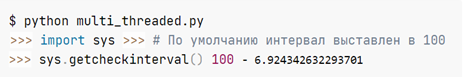

## Асинхронное выполнение потоков <a name="asynchronous"></a>

Асинхронная программа может одновременно обрабатывать задачи, но ее контекст переключается внутри, а не системным планировщиком.

## Библиотеки threading, multiprocessing и asyncio <a name="threading"></a>

In [23]:
from multiprocessing import Process

def print_func(continent='Asia'):
    print('The name of continent is : ', continent)

if __name__ == "__main__":  # confirms that the code is under main function
    names = ['America', 'Europe', 'Africa']
    procs = []
    proc = Process(target=print_func)  # instantiating without any argument
    procs.append(proc)
    proc.start()

    # instantiating process with arguments
    for name in names:
        # print(name)
        proc = Process(target=print_func, args=(name,))
        procs.append(proc)
        proc.start()

    # complete the processes
    for proc in procs:
        proc.join()

The name of continent is :  Asia
    
The name of continent is :  America
    
The name of continent is :  Europe
    
The name of continent is :  Africa

In [24]:
def print_name(prefix):
    print("Searching prefix:{}".format(prefix))
    try : 
        while True:
                # yeild used to create coroutine
                name = (yield)
                if prefix in name:
                    print(name)
    except GeneratorExit:
            print("Closing coroutine!!")
            
corou = print_name("Dear")
corou.__next__()
corou.send("James")
corou.send("Dear James")
corou.close()

Searching prefix:Dear
Dear James
Closing coroutine!!


Пример в котором запускаем 3 асинхронных таска, которые по-отдельности делают запросы к Reddit, извлекают и выводят содержимое JSON. 

Мы воспользовались aiohttp – клиентскую библиотеку http, которая гарантирует, что даже HTTP-запрос будет выполнен асинхронно.

In [ ]:
import signal  
import sys  
import asyncio  
import aiohttp  
import json

loop = asyncio.get_event_loop()  
client = aiohttp.ClientSession(loop=loop)

async def get_json(client, url):  
    async with client.get(url) as response:
        assert response.status == 200
        return await response.read()

async def get_reddit_top(subreddit, client):  
    data1 = await get_json(client, 'https://www.reddit.com/r/' + subreddit + '/top.json?sort=top&t=day&limit=5')

    j = json.loads(data1.decode('utf-8'))
    for i in j['data']['children']:
        score = i['data']['score']
        title = i['data']['title']
        link = i['data']['url']
        print(str(score) + ': ' + title + ' (' + link + ')')

    print('DONE:', subreddit + '\n')

def signal_handler(signal, frame):  
    loop.stop()
    client.close()
    sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)

asyncio.ensure_future(get_reddit_top('python', client))  
asyncio.ensure_future(get_reddit_top('programming', client))  
asyncio.ensure_future(get_reddit_top('compsci', client))  
loop.run_forever()

50: Undershoot: Parsing theory in 1965 (http://jeffreykegler.github.io/Ocean-of-Awareness-blog/individual/2018/07/knuth_1965_2.html)

12: Question about best-prefix/failure function/primal match table in kmp algorithm (https://www.reddit.com/r/compsci/comments/8xd3m2/question_about_bestprefixfailure_functionprimal/)

1: Question regarding calculating the probability of failure of a RAID system (https://www.reddit.com/r/compsci/comments/8xbkk2/question_regarding_calculating_the_probability_of/)

DONE: compsci

336: /r/thanosdidnothingwrong -- banning people with python (https://clips.twitch.tv/AstutePluckyCocoaLitty)

175: PythonRobotics: Python sample codes for robotics algorithms (https://atsushisakai.github.io/PythonRobotics/)

23: Python and Flask Tutorial in VS Code (https://code.visualstudio.com/docs/python/tutorial-flask)

17: Started a new blog on Celery - what would you like to read about? (https://www.python-celery.com)

14: A Simple Anomaly Detection Algorithm in Python (https://medium.com/@mathmare_/pyng-a-simple-anomaly-detection-algorithm-2f355d7dc054)

DONE: python

1360: git bundle (https://dev.to/gabeguz/git-bundle-2l5o)

1191: Which hashing algorithm is best for uniqueness and speed? Ian Boyd's answer (top voted) is one of the best comments I've seen on Stackexchange. (https://softwareengineering.stackexchange.com/questions/49550/which-hashing-algorithm-is-best-for-uniqueness-and-speed)

430: ARM launches “Facts” campaign against RISC-V (https://riscv-basics.com/)

244: Choice of search engine on Android nuked by “Anonymous Coward” (2009) (https://android.googlesource.com/platform/packages/apps/GlobalSearch/+/592150ac00086400415afe936d96f04d3be3ba0c)

209: Exploiting freely accessible WhatsApp data or “Why does WhatsApp web know my phone’s battery level?” (https://medium.com/@juan_cortes/exploiting-freely-accessible-whatsapp-data-or-why-does-whatsapp-know-my-battery-level-ddac224041b4)

DONE: programming

### Библиотека multiprocessing

In [ ]:
import os
from multiprocessing import Process
 
def doubler(number):
    """
    Функция умножитель на два
    """
    result = number * 2
    proc = os.getpid()
    print('{0} doubled to {1} by process id: {2}'.format(
        number, result, proc))
 
 
if __name__ == '__main__':
    numbers = [5, 10, 15, 20, 25]
    procs = []
    
    for index, number in enumerate(numbers):
        proc = Process(target=doubler, args=(number,))
        procs.append(proc)
        proc.start()
    
    for proc in procs:
        proc.join()

5 doubled to 10 by process id: 10468
    
10 doubled to 20 by process id: 10469
    
15 doubled to 30 by process id: 10470
    
20 doubled to 40 by process id: 10471
    
25 doubled to 50 by process id: 10472

In [ ]:
import os
from multiprocessing import Process, current_process

def doubler(number):
    result = number * 2
    proc_name = current_process().name
    print('{0} doubled to {1} by: {2}'.format(
        number, result, proc_name))
 
 
if __name__ == '__main__':
    numbers = [5, 10, 15, 20, 25]
    procs = []
    proc = Process(target=doubler, args=(5,))
    
    for index, number in enumerate(numbers):
        proc = Process(target=doubler, args=(number,))
        procs.append(proc)
        proc.start()
    
    proc = Process(target=doubler, name='Test', args=(2,))
    proc.start()
    procs.append(proc)
    
    for proc in procs:
        proc.join()

5 doubled to 10 by: Process-2
    
10 doubled to 20 by: Process-3
    
15 doubled to 30 by: Process-4
    
20 doubled to 40 by: Process-5
    
25 doubled to 50 by: Process-6
    
2 doubled to 4 by: Test

### Замки (Locks)
Модуль multiprocessing поддерживает замки так же, как и модуль threading. Все что вам нужно, это импортировать Lock, повесить его, сделать что-нибудь и снять его. Давайте посмотрим:

In [ ]:
from multiprocessing import Process, Lock

def printer(item, lock):
    """
    Выводим то что передали
    """
    lock.acquire()
    try:
        print(item)
    finally:
        lock.release()
 
 
if __name__ == '__main__':
    lock = Lock()
    items = ['tango', 'foxtrot', 10]
    
    for item in items:
        p = Process(target=printer, args=(item, lock))
        p.start()

### Логирование (Logging)

In [ ]:
import logging
import multiprocessing
from multiprocessing import Process, Lock

def printer(item, lock):
    """
    Выводим то что передали
    """
    lock.acquire()
    try:
        print(item)
    finally:
        lock.release()
 
 
if __name__ == '__main__':
    lock = Lock()
    items = ['tango', 'foxtrot', 10]
    multiprocessing.log_to_stderr()
    
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    
    for item in items:
        p = Process(target=printer, args=(item, lock))
        p.start()

[INFO/Process-1] child process calling self.run()

tango

[INFO/Process-1] process shutting down

[INFO/Process-1] process exiting with exitcode 0

[INFO/Process-2] child process calling self.run()

[INFO/MainProcess] process shutting down

foxtrot

[INFO/Process-2] process shutting down

[INFO/Process-3] child process calling self.run()

[INFO/Process-2] process exiting with exitcode 0

10

[INFO/MainProcess] calling join() for process Process-3

[INFO/Process-3] process shutting down

[INFO/Process-3] process exiting with exitcode 0

[INFO/MainProcess] calling join() for process Process-2

## Класс Pool
Класс Pool используется для показа пула рабочих процессов. Он включает в себя методы, которые позволяют вам разгружать задачи к рабочим процессам.

In [ ]:
from multiprocessing import Pool

def doubler(number):
    return number * 2

if __name__ == '__main__':
    numbers = [5, 10, 20]
    pool = Pool(processes=3)
    print(pool.map(doubler, numbers))

### Связь между процессами

In [ ]:
from multiprocessing import Process, Queue

sentinel = -1
 
def creator(data, q):
    """
    Creates data to be consumed and waits for the consumer
    to finish processing
    """
    print('Creating data and putting it on the queue')
    for item in data:
        q.put(item)
 
 
def my_consumer(q):
    """
    Consumes some data and works on it
    In this case, all it does is double the input
    """
    while True:
        data = q.get()
        print('data found to be processed: {}'.format(data))
    
        processed = data * 2
        print(processed)
    
        if data is sentinel:
            break
 
 
if __name__ == '__main__':
    q = Queue()
    data = [5, 10, 13, -1]
    
    process_one = Process(target=creator, args=(data, q))
    process_two = Process(target=my_consumer, args=(q,))
    
    process_one.start()
    process_two.start()
    
    q.close()
    q.join_thread()
    
    process_one.join()
    process_two.join()